In [1]:
import sys
sys.path.append('.')

In [2]:
from DataGen import DataGenerator, DataGenerator2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import clone_model
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print('No found GPU')

No found GPU


In [4]:
# Hyperparameters
input_dim = (28, 28, 3)
num_layers = 8
d_model = 64
dff = 256
num_heads = 4
max_sequence_length = input_dim[0] * input_dim[1]
dropout_rate = 0.1
lr = 0.002
batch_size = 64
epochs = 50
sess = tf.function()

In [3]:
experiment_folder = os.path.abspath(os.path.join('..', 'Experimentos'))
model_name = 'TRANSFORMER'
image_path = os.path.abspath(os.path.join('..', 'Dataset'))
data_path = os.path.join(image_path, 'wclasses.csv')

model_path = os.path.abspath(os.path.join(experiment_folder, model_name))
if not os.path.exists(model_path):
    os.mkdir(model_path)

if len(os.listdir(os.path.join(experiment_folder, model_name))) == 0:
    exp_id = 1
else:
    exp_id = len(os.listdir(os.path.join(experiment_folder, model_name))) + 1

current_experiment_path = os.path.join(experiment_folder, model_name, 'Exp_'+str(exp_id))
if not os.path.exists(current_experiment_path):
    os.mkdir(current_experiment_path)

In [29]:
def find_centroids(ds_train, num_clusters=16, batch_size=1024):
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size, verbose=True, n_init='auto')
    ds_batched = len(ds_train)
    for i in range(ds_batched):
        img, _ = ds_train[i]
        pixels = img.reshape(-1, img.shape[-1])
        kmeans.partial_fit(pixels)

    return kmeans.cluster_centers_

def unquantize(x):
    x_one_hot = tf.cast(tf.one_hot(x, depth=len(centroids)), dtype=tf.float16)  # (seq, num_centroids)
    #print(x_one_hot.dtype, centroids.dtype)
    result = tf.linalg.matmul(x_one_hot,centroids)  # (seq, num_features)
    return result

def np_showSeq(seq, size, max_images=3, cmap=None, epoch=0, filename='generated_plot'):
    """ Show one or more images encoded as sequence. (numpy version)

        seq: numpy array of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """ 
    batch = seq.shape[0]
    num_show_img = min(max_images, seq.shape[0])
    img = np.reshape(seq, (batch, *size, -1))
    if img.shape[-1] == 1:
      img = np.squeeze(img, axis=-1)    
    
    fig=plt.figure(figsize=(num_show_img-1, 3))
    for i in range(num_show_img):
        ax = fig.add_subplot(2, int(num_show_img/2), i+1)
        ax.set_axis_off()
        plt.imshow(img[i])
    file = filename + '_e%03d.png' % (epoch+1)
    path = os.path.join(current_experiment_path, file)
    plt.savefig(path)
    plt.show()
    plt.close()

def showSeq(seq, size, max_images=3, cmap=None, epoch=0, filename='generated_plot'):
    """ Show one or more images encoded as sequence. (tensorflow version)

        seq: tensor of sequences which encode the image. Either a single sequence or multiple sequences.
        size: the image size. e.g. (28, 28) for `mnist` images.
        max_images: the maximum number of images to display.
    """
    if cmap:
        seq = tf.map_fn(fn=unquantize, elems=seq, fn_output_signature=tf.float16)
    seq = tf.cast(seq, float).numpy()

    np_showSeq(seq, size, max_images, cmap, epoch, filename)

In [7]:
df = pd.read_csv(data_path, sep=',', encoding='ANSI')
# Load data
data_flow = DataGenerator(df, path_to_img=image_path, batch_size=batch_size, width=input_dim[0], height=input_dim[1], channels=input_dim[2], shuffle=True)
if os.path.exists(os.path.join(current_experiment_path, 'centroids.npy')):
    print('Centroids found')
    centroids = np.load(os.path.join(current_experiment_path, 'centroids.npy'))
else:
    centroids = find_centroids(data_flow, 256, 32)
    centroids = tf.convert_to_tensor(centroids, dtype=tf.float16)
    with open(os.path.join(current_experiment_path, 'centroids.npy'), 'wb') as f:
        np.save(f, centroids)
vocab_size = len(centroids)

# Dividimos el conjunto de entrenamiento y validación
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

data_flow = DataGenerator2(df_train, path_to_img=image_path, batch_size=batch_size, width=input_dim[0], height=input_dim[1], centroids=centroids, channels=input_dim[2], shuffle=True)
data_flow_val = DataGenerator2(df_val, path_to_img=image_path, batch_size=batch_size, width=input_dim[0], height=input_dim[1], centroids=centroids, channels=input_dim[2], shuffle=True)

Centroids found


In [8]:
hyperparams = {
    "input_dim":input_dim,
    "num_layers":num_layers,
    "d_model":d_model,
    "dff":dff,
    "num_heads":num_heads,
    "vocab_size":vocab_size,
    "max_sequence_length":max_sequence_length,
    "dropout_rate":dropout_rate,
    "learning rate":lr,
    "batch_size":batch_size,
    "epochs":epochs,
    "data_path":data_path
}

with open(os.path.join(current_experiment_path, 'hyperparams.json'), 'w') as f:
    json.dump(hyperparams, f)

In [8]:
def create_look_ahead_mask(size_q, size_k):
  mask = 1 - tf.linalg.band_part(tf.ones((size_q, size_k)), -1, 0)
  return mask  # (seq_len, seq_len)

In [9]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Any value to create and use a lookahead mask. 
          Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    mask = create_look_ahead_mask(tf.shape(q)[-2], tf.shape(k)[-2])
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [11]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      # tf.keras.activations.gelu(approximate=False), # tf-nightly
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [12]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    # t.shape == (batch_size, input_seq_len, d_model) 
    # for t in [x, out1, attn_out, res1, out2, ffn_out, res2]
    
    # masked multihead self-attention with residual connection
    out1 = self.layernorm1(self.dropout1(x, training=training)) 
    attn_out, attn_weights = self.mha(out1, out1, out1, mask) 
    res1 = x + attn_out

    # feed forward neural network with residual connection
    out2 = self.layernorm2(self.dropout2(res1, training=training))
    ffn_out = self.ffn(out2)
    res2 = res1 + ffn_out
    
    return res2, attn_weights

In [13]:
class DecoderBlock(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, vocab_size,
               maximum_position_encoding, rate=0.1):
    super(DecoderBlock, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.tok_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
    self.pos_embedding = tf.keras.layers.Embedding(maximum_position_encoding, d_model)                                            
        
    self.enc_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
    self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
  def call(self, x, training, mask):

    batch = tf.shape(x)[0]
    seq_len = tf.shape(x)[1]
    attention_weights = {}  

    # token and positional embedding
    positions = tf.expand_dims(tf.range(seq_len), axis=0)
    x = self.tok_embedding(x)  # (batch_size, input_seq_len, d_model)
    x = x + tf.tile(self.pos_embedding(positions), [batch, 1, 1])  # (batch_size, input_seq_len, d_model)
    
    # n * decoder layers
    for i in range(self.num_layers):
      x, attn_w = self.enc_layers[i](x, training, mask)
      attention_weights['decoder_layer{}'.format(i+1)] = attn_w

    # dropout and layer normalization
    x = self.dropout(x, training=training)
    x = self.layer_norm(x)
              
    return x, attention_weights  # (batch_size, input_seq_len, d_model)

In [14]:
class ImageTransformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,
               vocab_size, max_pos_encoding, rate=0.1):
    super(ImageTransformer, self).__init__()

    self.decoder = DecoderBlock(num_layers, d_model, num_heads, dff, 
                           vocab_size, max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(vocab_size)
    
  def call(self, inp, tar, training, mask):

    enc_output, attention_weights = self.decoder(inp, training, mask)  # (batch_size, inp_seq_len, d_model)    
    
    final_output = self.final_layer(enc_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [15]:
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.95, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  loss_ = loss_object(real, pred)  
  return tf.reduce_mean(loss_)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [16]:
transformer = ImageTransformer(num_layers, d_model, num_heads, dff, vocab_size,
                          max_pos_encoding=max_sequence_length, 
                          rate=dropout_rate)
print(f'num_layers: {num_layers}, d_model: {d_model}, num_heads: {num_heads}, dff: {dff}, vocab_size: {vocab_size}, max_pos_encoding: {max_sequence_length}, dropout_rate: {dropout_rate}')

num_layers: 8, d_model: 64, num_heads: 4, dff: 256, vocab_size: 256, max_pos_encoding: 784, dropout_rate: 0.1


In [17]:
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, current_experiment_path, max_to_keep=5)

In [18]:
if ckpt_manager.latest_checkpoint:
 ckpt.restore(ckpt_manager.latest_checkpoint)
 print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [19]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):  
  # add start of sequence token
  tar_inp = inp[:, :-1]
  tar_real = inp[:, 1:]
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(tar_inp, tar, 
                                 training=True, 
                                 mask=True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)

In [20]:
def generate_random_batch():
    seq = np.random.randint(centroids.shape[0], size=10*input_dim[0])
    seq = seq.reshape(10, input_dim[0])
    return seq

eval_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None), dtype=tf.int64),
]

@tf.function(input_signature=eval_step_signature)
def call_transformer(inp, tar):
    return transformer(inp, tar, training=False, mask=True)

def evaluate(inp_sequence):

  # remove half of the input 
  idx = int(inp_sequence.shape[-1] / 2) 
  seq = inp_sequence[:, :idx]

  # create target and transform to batched shape
  target = tf.expand_dims(tf.cast([0], dtype=tf.int64), axis=0)
  target = tf.tile(target, [seq.shape[0], 1])

  for _ in range(idx):
    logits, _ = call_transformer(seq, target)
    # apply softmax on the logits and return the result
    predictions = tf.random.categorical(logits[:, -1], 1, dtype=tf.int64)
    # append prediction
    seq = tf.concat([seq, predictions], axis=-1)

  return seq

def evaluate_random():
  inp_sequence = generate_random_batch()
    # create target and transform to batched shape
  target = tf.expand_dims(tf.cast([0], dtype=tf.int64), axis=0)
  target = tf.tile(target, [inp_sequence.shape[0], 1])

  for _ in range((input_dim[0]*input_dim[1])-input_dim[0]):
    logits, _ = call_transformer(inp_sequence, target)
    # apply softmax on the logits and return the result
    predictions = tf.random.categorical(logits[:, -1], 1, dtype=tf.int64)
    # append prediction
    inp_sequence = tf.concat([inp_sequence, predictions], axis=-1)

  return inp_sequence

def process_batch(inp=None, epoch=0):
  # showSeq(inp_sequence, (input_dim[0], input_dim[1]), inp_sequence.shape[0])
  if inp is None:
      result_seq = evaluate_random()
      showSeq(result_seq, (input_dim[0], input_dim[1]), 10, cmap='gray', epoch=epoch, filename='random_generation')
  else:
      result_seq = evaluate(inp)
      showSeq(result_seq, (input_dim[0], input_dim[1]), 10, cmap='gray', epoch=epoch, filename='image_reconstruction')

Epoch: 50/50 Step: 1272/1273 Loss: 2.2432
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16


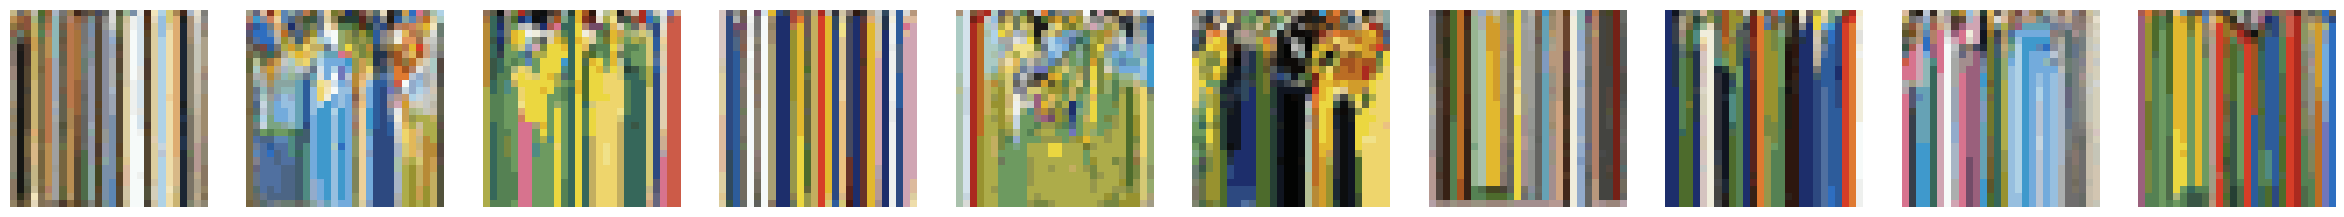

<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16
<dtype: 'float16'> float16


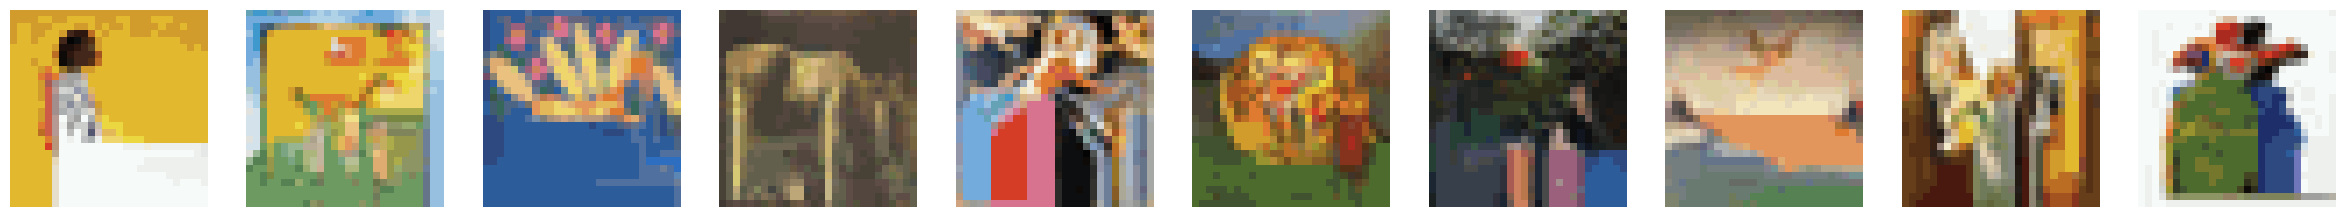

In [22]:
history = {'transformer_loss':[]}
for epoch in range(epochs):  
  train_loss.reset_states()
  running_loss = []
  print(f'Epoch {epoch+1}')
  for i in range(len(data_flow)):
    inp, tar = data_flow[i]
    train_step(inp, tar)
    running_loss.append(train_loss.result())
    clear_output(wait=True)
    print(f'Epoch: {epoch+1}/{epochs} Step: {i}/{len(data_flow)} Loss: {train_loss.result():.4f}')
    if i == 0:
        path = os.path.join(current_experiment_path, 'transformer.png')
        plot_model(transformer, to_file=path, show_shapes=True)
    #process_batch(inp)
  history['transformer_loss'].append(np.mean(running_loss))
  ckpt_save_path = ckpt_manager.save()
  if (epoch+1) % 10 == 0 or epoch == 0:
      #Save images
      process_batch(None, epoch)
      process_batch(inp[:10,:], epoch)

(64, 784)


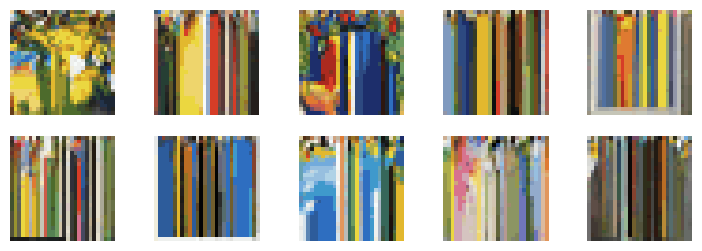

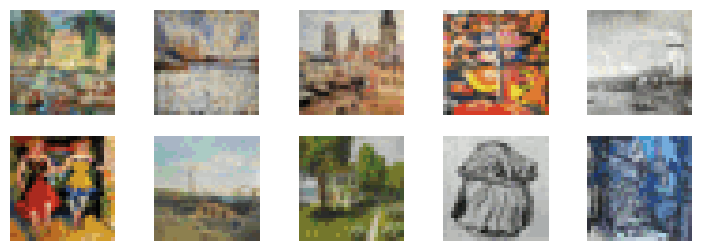

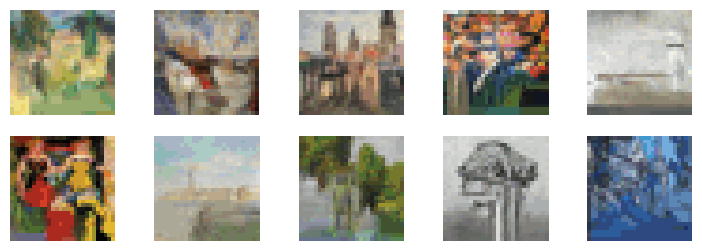

In [30]:
inp, _ = data_flow_val[0]
print(inp.shape)
process_batch()
showSeq(inp[:10,:], (input_dim[0], input_dim[1]), 10, cmap='gray', epoch=0, filename='original_validation_images')
process_batch(inp[:10,:])

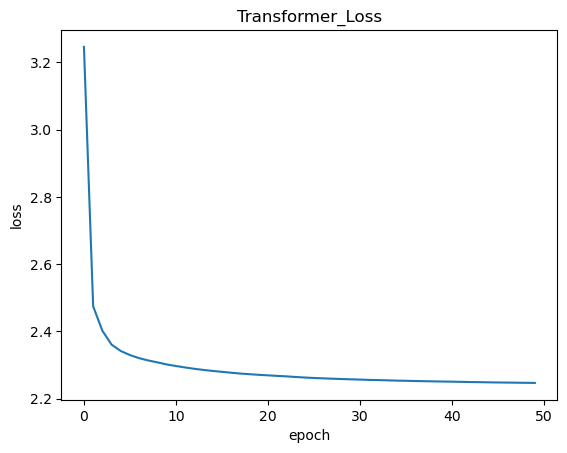

In [25]:
plt.plot(history['transformer_loss'])
plt.title('Transformer_Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# guardamos las imágenes
filename = 'transformer_loss.png'
path = os.path.join(current_experiment_path, filename)
plt.savefig(path)
plt.show()
plt.close()